<a href="https://colab.research.google.com/github/ali-workshop/Fire_detection_using-Deep-Learning/blob/main/Fire_detection_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

cwd= os.getcwd()

training_data_path= os.path.join(cwd,"Training and Validation")
testing_data_path= os.path.join(cwd,"Testing")

In [ ]:
import cv2
from pathlib import Path
from sklearn.ensemble import AdaBoostClassifier
from keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, precision_score
import seaborn as sb
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback
from PIL import Image

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)

In [ ]:
training_data_df= process_img(training_data_path)
testing_data_df= process_img(testing_data_path)

training_data_df.head()

,Filepath,Label
983,C:\Users\hadis\Thesis\Training and Validation\...,nofire
491,C:\Users\hadis\Thesis\Training and Validation\...,fire
211,C:\Users\hadis\Thesis\Training and Validation\...,fire
775,C:\Users\hadis\Thesis\Training and Validation\...,fire
1468,C:\Users\hadis\Thesis\Training and Validation\...,nofire


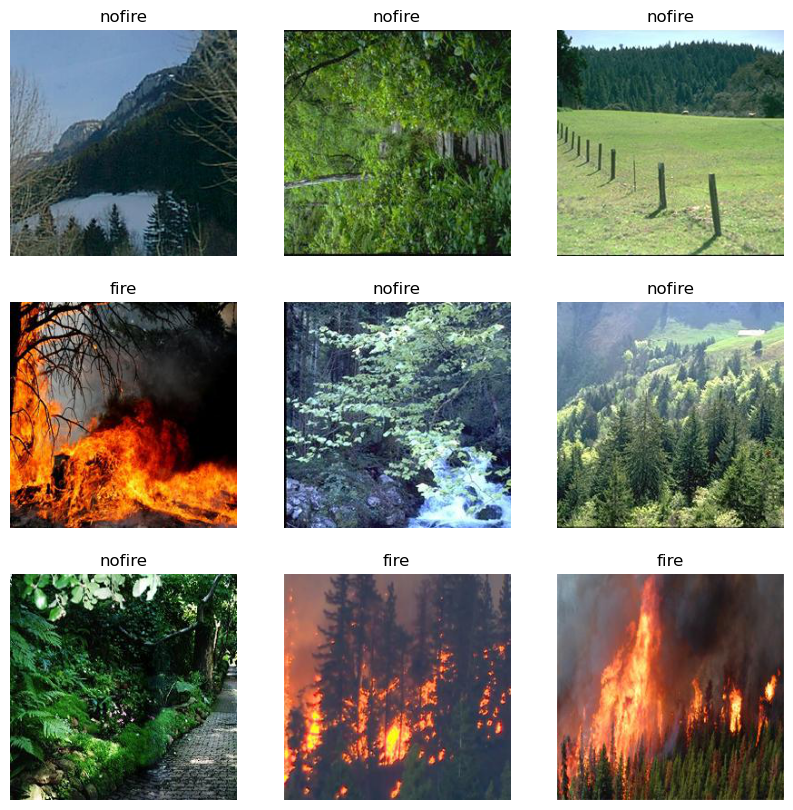

In [ ]:
def show_sample_images(df, num_images):

    # Randomly select a subset of images
    sample_df = df.sample(num_images)

    # Create a grid of subplots for displaying the images
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

    # Loop through each image and display it in a subplot
    for i, ax in enumerate(axs.flat):
        # Get the image and label from the dataframe
        img = plt.imread(sample_df.iloc[i].Filepath)
        label = sample_df.iloc[i].Label

        # Display the image in the subplot
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    # Show the plot
    plt.show()

show_sample_images(training_data_df,9)

In [ ]:
# We first create an ImageDataGenerator object with a rescaling factor of 1/255 so the model doesn't
# favor higher numbers
data_generator = ImageDataGenerator(dtype="float32",rescale=1./255)

# Just to handle an error
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def auc_plotter(auc):
    roc_auc= auc
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

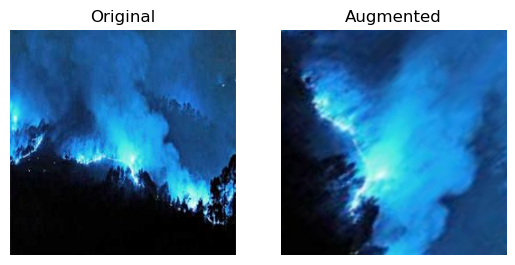

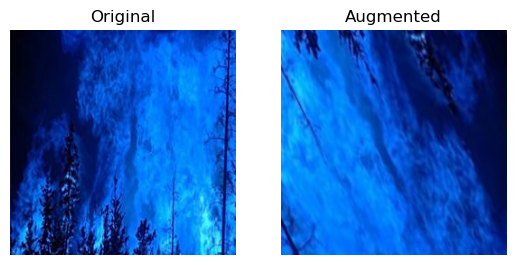

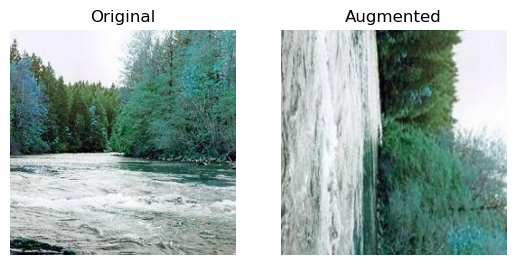

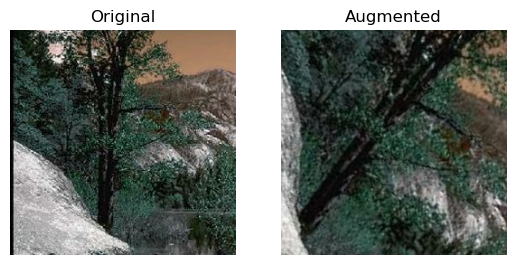

In [ ]:
def image_augmenter(image):
    datagen = ImageDataGenerator(rotation_range=180, zoom_range=[0.5, 1.0])
    image = np.expand_dims(image, axis=0)  # Add an extra dimension
    augmented_image = datagen.flow(x=image, batch_size=1)[0]
    augmented_image = augmented_image.squeeze(axis=0)  # Remove the extra dimension
    return augmented_image.astype(image.dtype)  # Preserve the data type of the input image

def show_original_vs_augmented(df, nsample):
    data = df.sample(nsample)
    for i in range(len(data)):
        image = cv2.imread(data.iloc[i].Filepath)
        augmented_image = image_augmenter(image)

        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Original")
        plt.subplot(1,2,2)
        plt.imshow(augmented_image)
        plt.title("Augmented")
        plt.axis('off')
        plt.show()

show_original_vs_augmented(training_data_df, 4)

### SVC

In [ ]:
# Define a generator for the training data
svm_augmented= ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function= image_augmenter )
svm_training_generator = svm_augmented.flow_from_dataframe(training_data_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                        shuffle=True,
                                        target_size = (128,128),
                                        class_mode = 'categorical')

# Define a generator for the testing data
svm_testing_generator = data_generator.flow_from_dataframe(
        testing_data_df,
        x_col='Filepath',
        y_col='Label',
        shuffle=True,
        target_size = (128,128),
        class_mode = 'categorical')

x_train, y_train = svm_training_generator.next()
x_test, y_test = svm_testing_generator.next()

# This converts the labels back to their original indices since they are of the form of one-hot-encoded
# vector, the result is a 1D array of class indices, representing class labels for corresponding images in X_train
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# Flatten the images into a 2D array, since SVMs expect 2D input arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Found 1832 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


In [ ]:
# Define the hyperparameter grid for SVC
svm_param_grid = {'C':[0.5,1,2],
                 'degree':[2,3,4],
                 'kernel':['rbf'],
                 'gamma':['scale','auto'],
                 'random_state':[101],
                 }

In [ ]:
svm_model= GridSearchCV(SVC(kernel='rbf'), svm_param_grid, refit= True, verbose= 3)

svm_model.fit(x_train, y_train)

best_svm_params= svm_model.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END C=0.5, degree=2, gamma=scale, kernel=rbf, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END C=0.5, degree=2, gamma=scale, kernel=rbf, random_state=101;, score=0.571 total time=   0.0s
[CV 3/5] END C=0.5, degree=2, gamma=scale, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 4/5] END C=0.5, degree=2, gamma=scale, kernel=rbf, random_state=101;, score=0.500 total time=   0.0s
[CV 5/5] END C=0.5, degree=2, gamma=scale, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END C=0.5, degree=2, gamma=auto, kernel=rbf, random_state=101;, score=0.429 total time=   0.0s
[CV 2/5] END C=0.5, degree=2, gamma=auto, kernel=rbf, random_state=101;, score=0.429 total time=   0.0s
[CV 3/5] END C=0.5, degree=2, gamma=auto, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 4/5] END C=0.5, degree=2, gamma=auto, kernel=rbf, random_state=101;, score=0.667 total time=   0.0

[CV 5/5] END C=2, degree=3, gamma=auto, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END C=2, degree=4, gamma=scale, kernel=rbf, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END C=2, degree=4, gamma=scale, kernel=rbf, random_state=101;, score=0.714 total time=   0.0s
[CV 3/5] END C=2, degree=4, gamma=scale, kernel=rbf, random_state=101;, score=1.000 total time=   0.0s
[CV 4/5] END C=2, degree=4, gamma=scale, kernel=rbf, random_state=101;, score=0.500 total time=   0.0s
[CV 5/5] END C=2, degree=4, gamma=scale, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END C=2, degree=4, gamma=auto, kernel=rbf, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END C=2, degree=4, gamma=auto, kernel=rbf, random_state=101;, score=0.571 total time=   0.0s
[CV 3/5] END C=2, degree=4, gamma=auto, kernel=rbf, random_state=101;, score=0.667 total time=   0.0s
[CV 4/5] END C=2, degree=4, gamma=auto, kernel=rbf, random_state=101;, score=

In [ ]:
y_pred = svm_model.predict(x_test)
print(best_svm_params)
print('\n-----------------------SVM-----------------------\n')
print(classification_report(y_test,y_pred))

{'C': 2, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 101}

-----------------------SVM-----------------------

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.89      0.94      0.92        18

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32



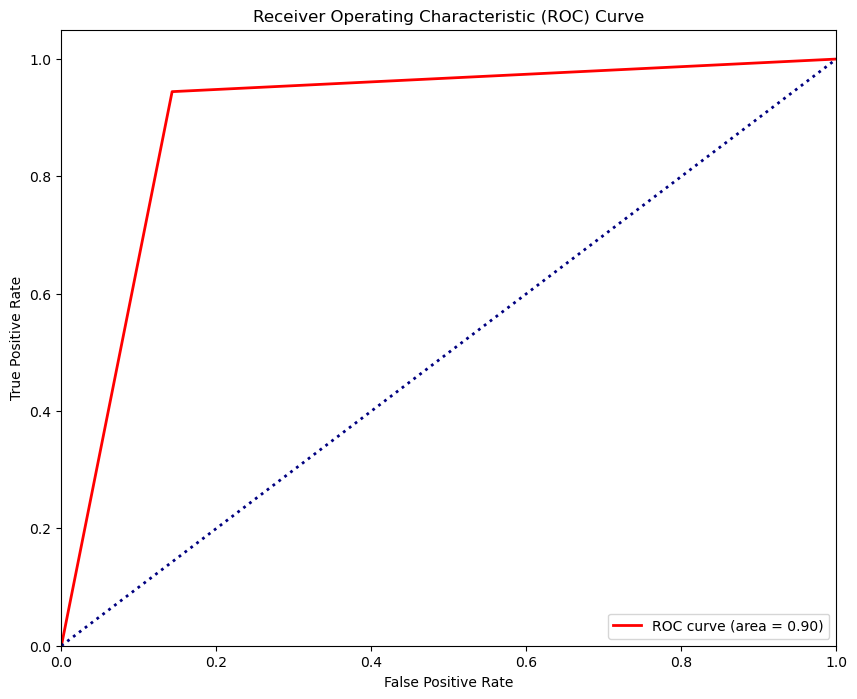

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_svm = auc(fpr, tpr)

auc_plotter(roc_auc_svm)

### Random Forest Classifier

In [ ]:
# Define a generator for the training data
rf_augmented= ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=image_augmenter)
rf_training_generator = rf_augmented.flow_from_dataframe(training_data_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                        shuffle=True,
                                        target_size = (128,128),
                                        class_mode = 'categorical')

# Define a generator for the testing data
rf_testing_generator = data_generator.flow_from_dataframe(
        testing_data_df,
        x_col='Filepath',
        y_col='Label',
        shuffle=True,
        target_size = (128,128),
        class_mode = 'categorical')


x_train, y_train = rf_training_generator.next()
x_test, y_test = rf_testing_generator.next()

# This converts the labels back to their original indices since they are of the form of one-hot-encoded
# vector, the result is a 1D array of class indices, representing class labels for corresponding images in X_train
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# Flatten the images into a 2D array, since SVMs expect 2D input arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Found 1832 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


In [ ]:
# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'max_depth': [None],
    'n_estimators': [50,100,150],
    'criterion': ['gini','entropy'],
    'max_features':['sqrt','log2',None],
    'min_samples_split': [2,3,4],
    'random_state': [101]
}

In [ ]:
rf_model= GridSearchCV(RandomForestClassifier(), rf_param_grid, refit= True, verbose= 3)

rf_model.fit(x_train, y_train)

best_rf_params= rf_model.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=101;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=101;, score=0.833 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=101;, score=0.667 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=101;, score=0.857 total time=   0.1s
[CV 2/5] END criterion=gi

[CV 1/5] END criterion=gini, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=150, random_state=101;, score=0.857 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=150, random_state=101;, score=0.857 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=150, random_state=101;, score=0.667 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=150, random_state=101;, score=0.833 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=150, random_state=101;, score=0.667 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=None, max_features=log2, min_samples_split=3, n_estimators=50, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, max_features=log2, min_samples_split=3

[CV 5/5] END criterion=gini, max_depth=None, max_features=None, min_samples_split=3, n_estimators=50, random_state=101;, score=0.667 total time=   4.2s
[CV 1/5] END criterion=gini, max_depth=None, max_features=None, min_samples_split=3, n_estimators=100, random_state=101;, score=0.714 total time=   8.4s
[CV 2/5] END criterion=gini, max_depth=None, max_features=None, min_samples_split=3, n_estimators=100, random_state=101;, score=0.857 total time=   8.7s
[CV 3/5] END criterion=gini, max_depth=None, max_features=None, min_samples_split=3, n_estimators=100, random_state=101;, score=0.833 total time=   8.7s
[CV 4/5] END criterion=gini, max_depth=None, max_features=None, min_samples_split=3, n_estimators=100, random_state=101;, score=0.667 total time=   8.7s
[CV 5/5] END criterion=gini, max_depth=None, max_features=None, min_samples_split=3, n_estimators=100, random_state=101;, score=0.667 total time=   8.8s
[CV 1/5] END criterion=gini, max_depth=None, max_features=None, min_samples_split=3

[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_split=3, n_estimators=150, random_state=101;, score=0.667 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_split=3, n_estimators=150, random_state=101;, score=0.667 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=101;, score=0.857 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=101;, score=1.000 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=101;, score=0.833 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_split=4, n_estimators=50, random_state=101;, score=0.667 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, m

[CV 3/5] END criterion=entropy, max_depth=None, max_features=log2, min_samples_split=4, n_estimators=100, random_state=101;, score=0.667 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=None, max_features=log2, min_samples_split=4, n_estimators=100, random_state=101;, score=0.833 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=None, max_features=log2, min_samples_split=4, n_estimators=100, random_state=101;, score=0.667 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=None, max_features=log2, min_samples_split=4, n_estimators=150, random_state=101;, score=0.857 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=None, max_features=log2, min_samples_split=4, n_estimators=150, random_state=101;, score=0.857 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=None, max_features=log2, min_samples_split=4, n_estimators=150, random_state=101;, score=0.833 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=None, max_features=log

In [ ]:
y_pred = rf_model.predict(x_test)
print(best_rf_params)
print('\n-----------------------RF-----------------------\n')
print(classification_report(y_test,y_pred))

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 101}

-----------------------RF-----------------------

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.87      0.91      0.89        22

    accuracy                           0.84        32
   macro avg       0.82      0.80      0.81        32
weighted avg       0.84      0.84      0.84        32



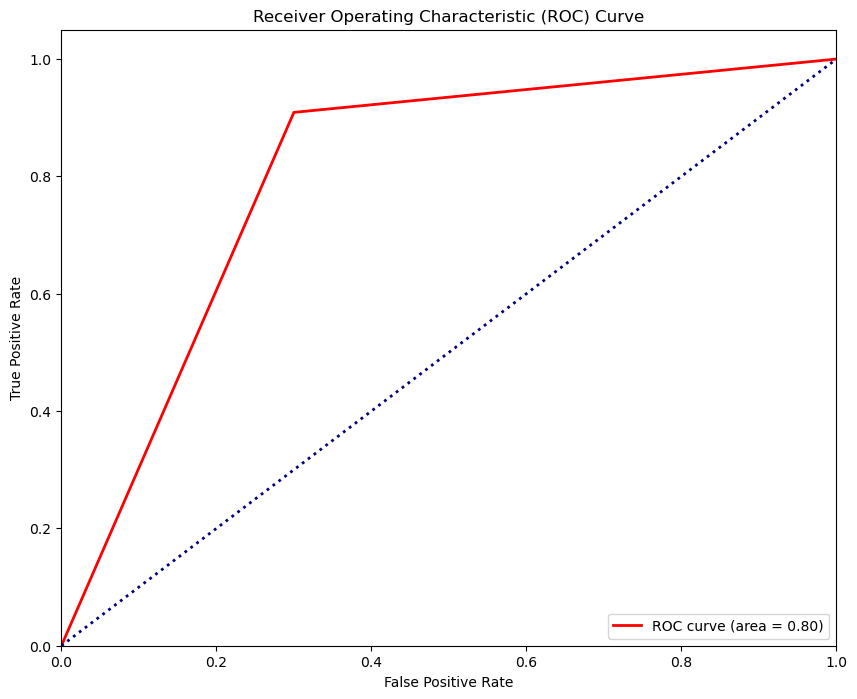

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr, tpr)

auc_plotter(roc_auc_rf)

### XGBoost - PCA

In [ ]:
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [ ]:
# Define a generator for the training data
xgb_augmented= ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=image_augmenter)
xgb_training_generator = xgb_augmented.flow_from_dataframe(training_data_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                        shuffle=True,
                                        batch_size=32,
                                        target_size=(128, 128),
                                        class_mode='categorical')

# Define a generator for the testing data
xgb_testing_generator = data_generator.flow_from_dataframe(
        testing_data_df,
        x_col='Filepath',
        y_col='Label',
        shuffle=True,
        batch_size=32,
        target_size=(128, 128),
        class_mode='categorical')

x_train, y_train = xgb_training_generator.next()
x_test, y_test = xgb_testing_generator.next()

# This converts the labels back to their original indices since they are of the form of one-hot-encoded
# vector, the result is a 1D array of class indices, representing class labels for corresponding images in X_train
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# Flatten the images into a 2D array, since SVMs expect 2D input arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Found 1832 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


In [ ]:
# Define the hyperparameter grid for XGBoost Classifier
xgb_param_grid = {'eta':[0.05,0.1,0.3],
              'min_child_weight': [0.5,1,2],
              'max_depth': [2,3,4],
              'gamma': [0,0.1,1,10],
              'seed': [101]}

In [ ]:
print(x_train.shape, x_test.shape)

# The .98 is a parameter that indicates the principal components required to explain 98% of the variance in the dataset
pca= PCA(.98)

pca_train= pca.fit_transform(x_train)
pca_test= pca.transform(x_test)
print('-----After PCA-------\n')
print(pca_train.shape, pca_test.shape)
print("Number of Components: ", pca.n_components_)
print("Number of Original Features: ", pca.n_features_)

(32, 49152) (32, 49152)
-----After PCA-------

(32, 26) (32, 26)
Number of Components:  26
Number of Original Features:  49152


In [ ]:
xgb_model_pca = GridSearchCV(XGBClassifier(), xgb_param_grid, refit=True, verbose=3)

# Train your SVM model on the entire training data
xgb_model_pca.fit(pca_train, y_train)
best_params = xgb_model_pca.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.429 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=0.5, seed=101;, score=0.667 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=0.571 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=0, max_depth=2, min_child_weight=1, seed=1

[CV 4/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=2, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=2, seed=101;, score=0.857 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=0.1, max_depth=4, min_child_weight=2, seed=101;, score=0.667 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=1, max_depth=2, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=1, max_depth=2, min_child_weight=0.5, seed=101;, score=0.571 total time=   0.0s
[CV 3/5] END eta=0.

[CV 5/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=0.5, seed=101;, score=0.500 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=1, seed=101;, score=0.571 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=1, seed=101;, score=0.571 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 4/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 5/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=1, seed=101;, score=0.500 total time=   0.0s
[CV 1/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=2, seed=101;, score=0.571 total time=   0.0s
[CV 2/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=2, seed=101;, score=0.571 total time=   0.0s
[CV 3/5] END eta=0.05, gamma=10, max_depth=4, min_child_weight=2, seed=101;, score=0.667 total time=   0.0s
[CV 4/5] END eta=0.05, gam

[CV 3/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 1/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=2, seed=101;, score=0.571 total time=   0.0s
[CV 2/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=2, seed=101;, score=0.857 total time=   0.0s
[CV 3/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.1, gamma=0.1, max_depth=3, min_child_weight=2, seed=101;, score=0.667 total time=   0.0s
[CV 1/5] END eta=0.1, gamma=0.1, max_depth=4, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.1, gamm

[CV 4/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=0.5, seed=101;, score=0.667 total time=   0.0s
[CV 5/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=0.5, seed=101;, score=0.500 total time=   0.0s
[CV 1/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.571 total time=   0.0s
[CV 2/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.571 total time=   0.0s
[CV 3/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 4/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 5/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=1, seed=101;, score=0.500 total time=   0.0s
[CV 1/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=2, seed=101;, score=0.571 total time=   0.0s
[CV 2/5] END eta=0.1, gamma=10, max_depth=3, min_child_weight=2, seed=101;, score=0.571 total time=   0.0s
[CV 3/5] END eta=0.1, gamma=10, m

[CV 3/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=1.000 total time=   0.0s
[CV 3/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.833 total time=   0.0s
[CV 5/5] END eta=0.3, gamma=0.1, max_depth=2, min_child_weight=2, seed=101;, score=0.667 total time=   0.0s
[CV 1/5] END eta=0.3, gamma=0.1, max_depth=3, min_child_weight=0.5, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.3, gamm

[CV 4/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=0.5, seed=101;, score=0.667 total time=   0.0s
[CV 5/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=0.5, seed=101;, score=0.500 total time=   0.0s
[CV 1/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=0.571 total time=   0.0s
[CV 3/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=0.833 total time=   0.0s
[CV 4/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=0.667 total time=   0.0s
[CV 5/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=1, seed=101;, score=0.500 total time=   0.0s
[CV 1/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=2, seed=101;, score=0.714 total time=   0.0s
[CV 2/5] END eta=0.3, gamma=10, max_depth=2, min_child_weight=2, seed=101;, score=0.571 total time=   0.0s
[CV 3/5] END eta=0.3, gamma=10, m

In [ ]:
y_pred = xgb_model_pca.predict(pca_test)
print(best_params)
print('\n-----------------------XGB-----------------------\n')
print(classification_report(y_test,y_pred))

{'eta': 0.3, 'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'seed': 101}

-----------------------XGB-----------------------

              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.78      0.86      0.82        21

    accuracy                           0.75        32
   macro avg       0.72      0.70      0.71        32
weighted avg       0.74      0.75      0.74        32



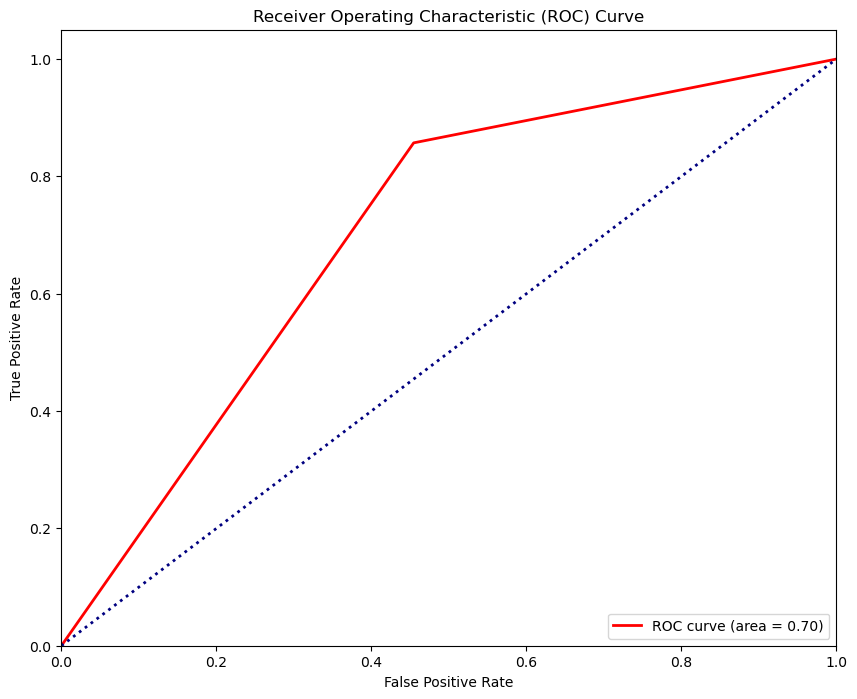

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_xgb = auc(fpr, tpr)

auc_plotter(roc_auc_xgb)

### AdaBoost

In [ ]:
# Define a generator for the training data
ab_augmented= ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=image_augmenter)
ab_training_generator = ab_augmented.flow_from_dataframe(training_data_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                        shuffle=True,
                                        target_size = (64,64),
                                        class_mode = 'categorical')

# Define a generator for the testing data
ab_testing_generator = data_generator.flow_from_dataframe(
        testing_data_df,
        x_col='Filepath',
        y_col='Label',
        shuffle=True,
        target_size = (64,64),
        class_mode = 'categorical')


x_train, y_train = ab_training_generator.next()
x_test, y_test =ab_testing_generator.next()

# This converts the labels back to their original indices since they are of the form of one-hot-encoded
# vector, the result is a 1D array of class indices, representing class labels for corresponding images in X_train
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# Flatten the images into a 2D array, since SVMs expect 2D input arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Found 1832 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


In [ ]:
# Define the hyperparameter grid for AdaBoost Classifier
ab_param_grid = {
                'n_estimators':[50,100,150],
                'learning_rate':[0.01,0.1,1]
}

In [ ]:
base_model= AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=1))

ab_model= GridSearchCV(base_model, ab_param_grid, refit= True, verbose= 3)

ab_model.fit(x_train, y_train)

best_ab_params= ab_model.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=0.571 total time=   1.6s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=0.571 total time=   1.6s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=0.667 total time=   1.7s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=0.500 total time=   1.7s
[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=0.667 total time=   1.7s
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.571 total time=   3.4s
[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=0.571 total time=   3.4s
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.667 total time=   3.5s
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.500 total time=   3.4s
[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=0.667 total time=   3.5s
[CV 1/5] END learning_rate=0.01, n_estimators=150;, score=0.429 total time=   5.3s
[CV 2/5] END learning_rate=0.01,

In [ ]:
y_pred = ab_model.predict(x_test)
print(best_ab_params)
print('\n---------------------AdaBoost---------------------\n')
print(classification_report(y_test,y_pred))

{'learning_rate': 1, 'n_estimators': 50}

---------------------AdaBoost---------------------

              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.75      0.90      0.82        20

    accuracy                           0.75        32
   macro avg       0.75      0.70      0.71        32
weighted avg       0.75      0.75      0.74        32



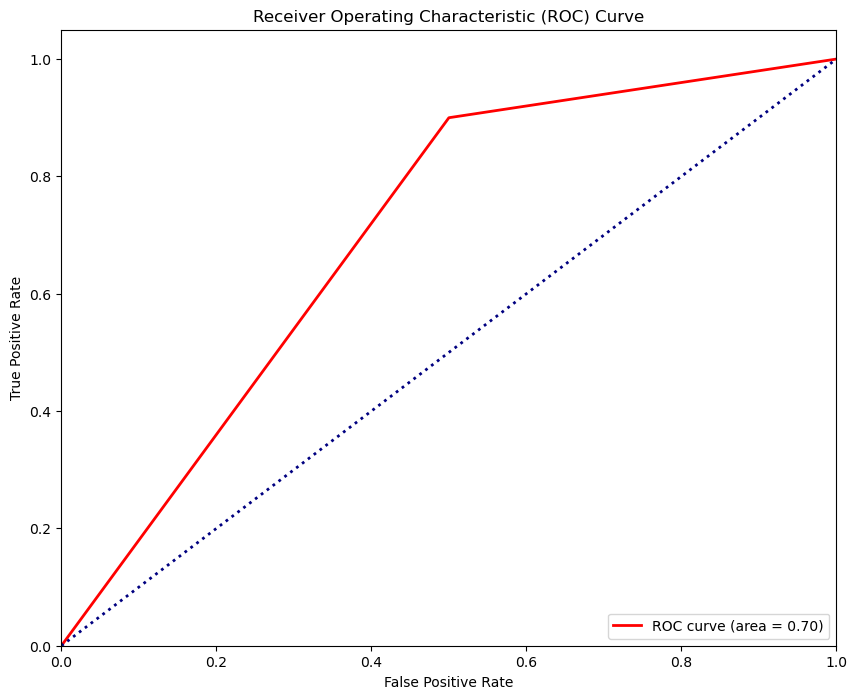

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_ab = auc(fpr, tpr)

auc_plotter(roc_auc_ab)

### CNN Model

In [ ]:
!wandb login

wandb: Currently logged in as: user_88. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.init(project='social_media_posts', entity='user_88')

wandb: Currently logged in as: user_88. Use `wandb login --relogin` to force relogin


In [ ]:
training_df, val_df = train_test_split(training_data_df, test_size=0.2, random_state=42)

In [ ]:
##We will choose a batch size of 256, since it leads to a more stable and efficient training, due to its larger size
##We will choose the 'categorical' class_mode since our classes are not 0 and 1, so it reduces the hassle of converting the class types

tr_dg= ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=image_augmenter)
training_generator = tr_dg.flow_from_dataframe(training_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = 32,
                                                    target_size = (256,256),
                                                    class_mode = 'categorical')

val_dg = ImageDataGenerator(dtype='float32', rescale= 1./255.)
validation_generator = val_dg.flow_from_dataframe(val_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = 32,
                                                    target_size = (256,256),
                                                    class_mode = 'categorical')
te_dg = ImageDataGenerator(dtype='float32', rescale= 1./255.)
testing_generator = te_dg.flow_from_dataframe(testing_data_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=False,
                                                    batch_size = 32,
                                                    target_size = (256,256),
                                                    class_mode = 'categorical')

Found 1465 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


In [ ]:
inputs = Input(shape=(256, 256, 3))

##Convolutional Layer 1
x = Conv2D(filters = 8, kernel_size=2)(inputs)
x = MaxPooling2D()(x)

##Convolutional Layer 2
x = Conv2D(filters = 16, kernel_size=2)(x)
x = MaxPooling2D()(x)

##Convolutional Layer 3
#x = Conv2D(filters = 32, kernel_size=2)(x)
#x = MaxPooling2D()(x)

##Fully Connected Layer 1 with Dropout function to reduce overfitting
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(.3)(x)

##Fully Connected Layer 2 with Dropout function to reduce overfitting
x = Dense(128, activation="relu")(x)
x = Dropout(.3)(x)

##Output Layer
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

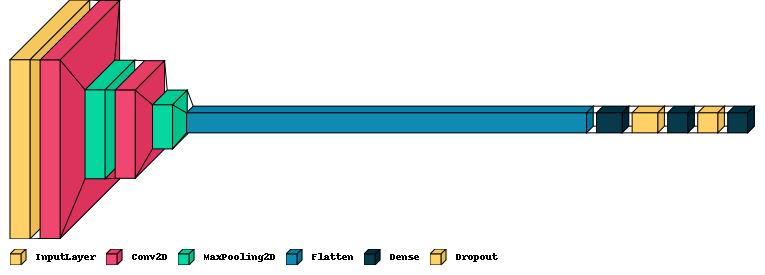

In [ ]:
from PIL import ImageFont
import visualkeras

visualkeras.layered_view(model,scale_xy=0.7,legend= True)

In [ ]:
model.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)
checkpoint = ModelCheckpoint('model.hdf6',verbose=1, save_best_only= True)
stopping = EarlyStopping(monitor= 'val_loss', patience= 9)

history = model.fit(training_generator,
                    epochs = 50,
                    verbose = 1,
                    validation_data = validation_generator,
                    callbacks = [wandb.keras.WandbCallback(), checkpoint, stopping])


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 1.2786 - accuracy: 0.7570 - auc: 0.8097

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best)... Done. 0.5s



Epoch 00001: val_loss improved from inf to 0.21304, saving model to model.hdf6


INFO:tensorflow:Assets written to: model.hdf6\assets


INFO:tensorflow:Assets written to: model.hdf6\assets


46/46 [==============================] - 56s 1s/step - loss: 1.2786 - accuracy: 0.7570 - auc: 0.8097 - val_loss: 0.2130 - val_accuracy: 0.9183 - val_auc: 0.9793
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9154 - auc: 0.9673
Epoch 00002: val_loss did not improve from 0.21304
46/46 [==============================] - 41s 890ms/step - loss: 0.2389 - accuracy: 0.9154 - auc: 0.9673 - val_loss: 0.2443 - val_accuracy: 0.8801 - val_auc: 0.9643
Epoch 3/50
46/46 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9256 - auc: 0.9668

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best)... Done. 0.5s



Epoch 00003: val_loss improved from 0.21304 to 0.19548, saving model to model.hdf6


INFO:tensorflow:Assets written to: model.hdf6\assets


INFO:tensorflow:Assets written to: model.hdf6\assets


46/46 [==============================] - 47s 1s/step - loss: 0.2235 - accuracy: 0.9256 - auc: 0.9668 - val_loss: 0.1955 - val_accuracy: 0.9292 - val_auc: 0.9796
Epoch 4/50
46/46 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9263 - auc: 0.9713
Epoch 00004: val_loss did not improve from 0.19548
46/46 [==============================] - 40s 857ms/step - loss: 0.2147 - accuracy: 0.9263 - auc: 0.9713 - val_loss: 0.2093 - val_accuracy: 0.9210 - val_auc: 0.9769
Epoch 5/50
46/46 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9290 - auc: 0.9758

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best)... Done. 1.2s



Epoch 00005: val_loss improved from 0.19548 to 0.18484, saving model to model.hdf6


INFO:tensorflow:Assets written to: model.hdf6\assets


INFO:tensorflow:Assets written to: model.hdf6\assets


46/46 [==============================] - 45s 988ms/step - loss: 0.1951 - accuracy: 0.9290 - auc: 0.9758 - val_loss: 0.1848 - val_accuracy: 0.9346 - val_auc: 0.9791
Epoch 6/50
46/46 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9358 - auc: 0.9764

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best)... Done. 0.5s



Epoch 00006: val_loss improved from 0.18484 to 0.18471, saving model to model.hdf6


INFO:tensorflow:Assets written to: model.hdf6\assets


INFO:tensorflow:Assets written to: model.hdf6\assets


46/46 [==============================] - 44s 965ms/step - loss: 0.1805 - accuracy: 0.9358 - auc: 0.9764 - val_loss: 0.1847 - val_accuracy: 0.9319 - val_auc: 0.9784
Epoch 7/50
46/46 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9372 - auc: 0.9720
Epoch 00007: val_loss did not improve from 0.18471
46/46 [==============================] - 38s 829ms/step - loss: 0.1999 - accuracy: 0.9372 - auc: 0.9720 - val_loss: 0.2005 - val_accuracy: 0.9455 - val_auc: 0.9745
Epoch 8/50
46/46 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9406 - auc: 0.9749

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best)... Done. 0.8s



Epoch 00008: val_loss improved from 0.18471 to 0.18164, saving model to model.hdf6


INFO:tensorflow:Assets written to: model.hdf6\assets


INFO:tensorflow:Assets written to: model.hdf6\assets


46/46 [==============================] - 59s 1s/step - loss: 0.1818 - accuracy: 0.9406 - auc: 0.9749 - val_loss: 0.1816 - val_accuracy: 0.9428 - val_auc: 0.9764
Epoch 9/50
46/46 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9352 - auc: 0.9781

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best)... Done. 1.4s



Epoch 00009: val_loss improved from 0.18164 to 0.16787, saving model to model.hdf6


INFO:tensorflow:Assets written to: model.hdf6\assets


INFO:tensorflow:Assets written to: model.hdf6\assets


46/46 [==============================] - 62s 1s/step - loss: 0.1824 - accuracy: 0.9352 - auc: 0.9781 - val_loss: 0.1679 - val_accuracy: 0.9510 - val_auc: 0.9775
Epoch 10/50
46/46 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9338 - auc: 0.9750
Epoch 00010: val_loss did not improve from 0.16787
46/46 [==============================] - 53s 1s/step - loss: 0.1859 - accuracy: 0.9338 - auc: 0.9750 - val_loss: 0.1702 - val_accuracy: 0.9455 - val_auc: 0.9795
Epoch 11/50
46/46 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9372 - auc: 0.9734
Epoch 00011: val_loss did not improve from 0.16787
46/46 [==============================] - 53s 1s/step - loss: 0.1969 - accuracy: 0.9372 - auc: 0.9734 - val_loss: 0.1785 - val_accuracy: 0.9373 - val_auc: 0.9788
Epoch 12/50
46/46 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9440 - auc: 0.9782
Epoch 00012: val_loss did not improve from 0.16787
46/46 [==============================

INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\hadis\Thesis\wandb\run-20230808_163034-s90mmh9q\files\model-best)... Done. 0.8s



Epoch 00018: val_loss improved from 0.16787 to 0.15122, saving model to model.hdf6


INFO:tensorflow:Assets written to: model.hdf6\assets


INFO:tensorflow:Assets written to: model.hdf6\assets


46/46 [==============================] - 57s 1s/step - loss: 0.1968 - accuracy: 0.9317 - auc: 0.9746 - val_loss: 0.1512 - val_accuracy: 0.9619 - val_auc: 0.9829
Epoch 19/50
46/46 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9324 - auc: 0.9729
Epoch 00019: val_loss did not improve from 0.15122
46/46 [==============================] - 37s 805ms/step - loss: 0.2129 - accuracy: 0.9324 - auc: 0.9729 - val_loss: 0.2709 - val_accuracy: 0.8856 - val_auc: 0.9547
Epoch 20/50
46/46 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9386 - auc: 0.9800
Epoch 00020: val_loss did not improve from 0.15122
46/46 [==============================] - 37s 809ms/step - loss: 0.1745 - accuracy: 0.9386 - auc: 0.9800 - val_loss: 0.1686 - val_accuracy: 0.9537 - val_auc: 0.9827
Epoch 21/50
46/46 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9474 - auc: 0.9800
Epoch 00021: val_loss did not improve from 0.15122
46/46 [========================

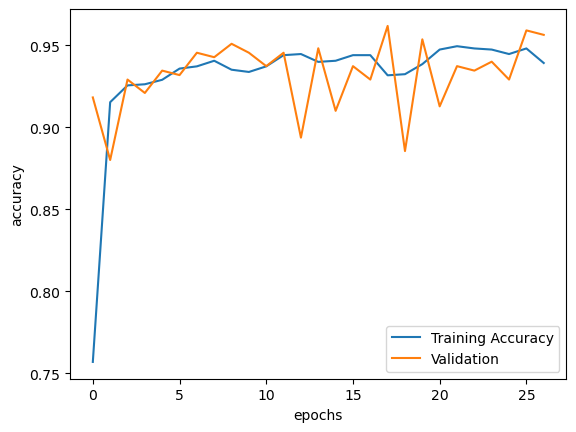

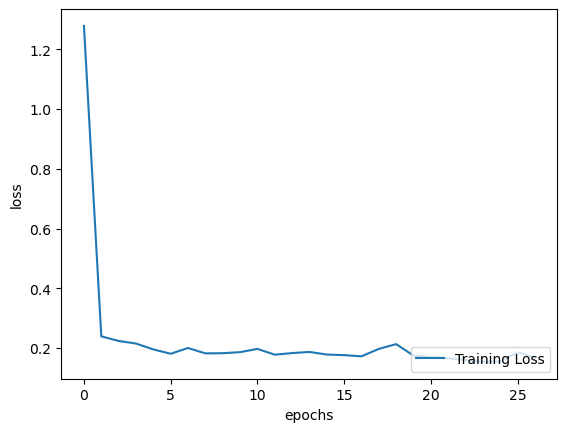

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation')

plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

3/3 [==============================] - 0s 98ms/step
Accuracy score: 91.17647058823529


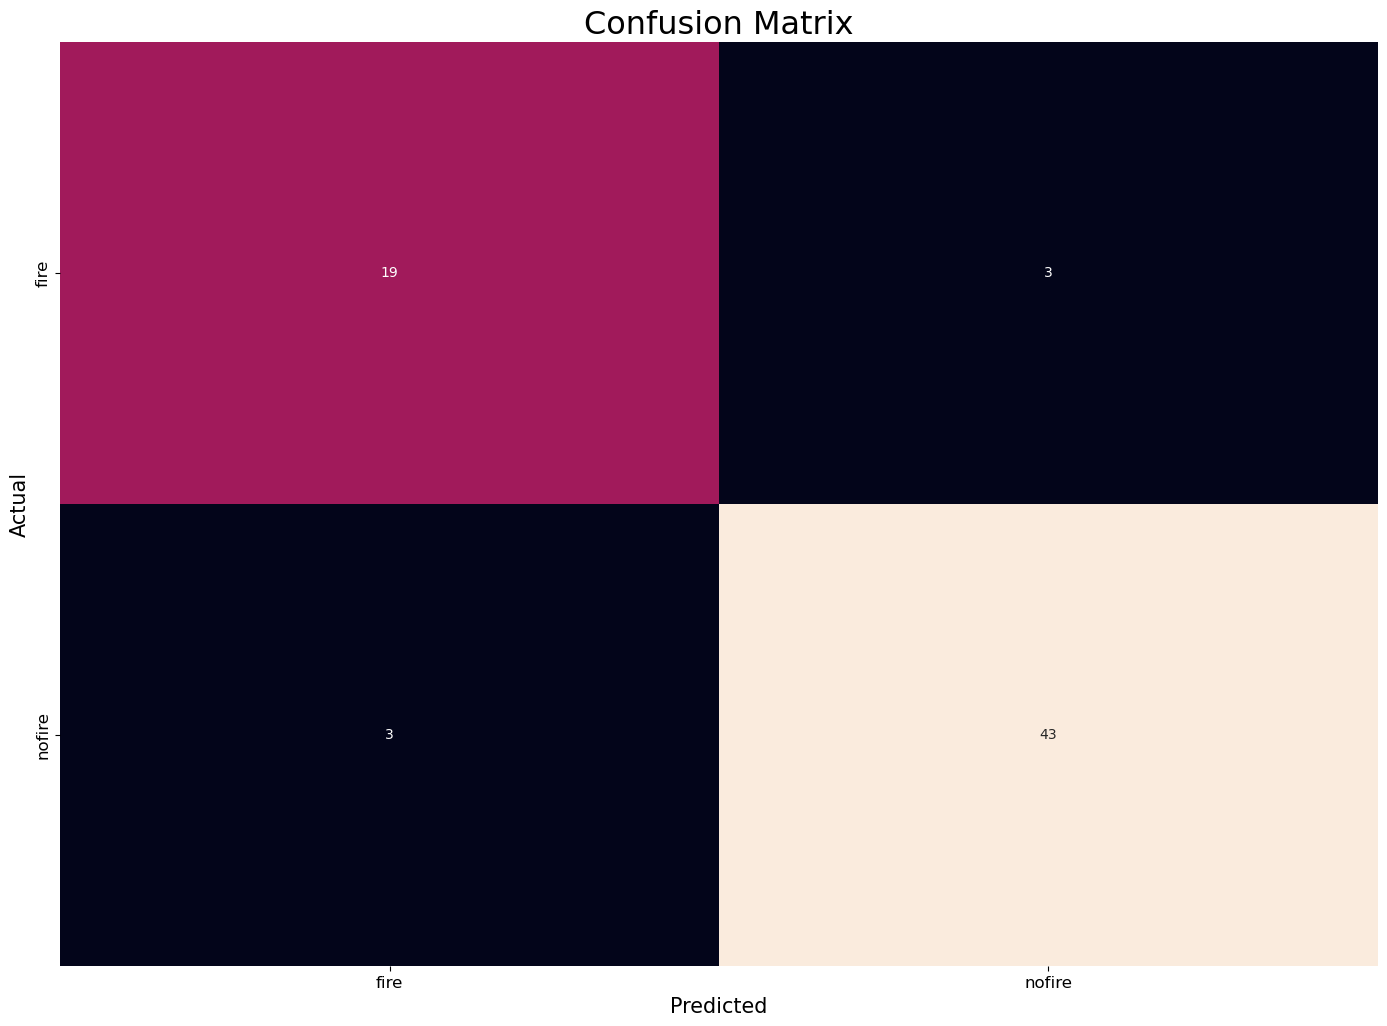

In [ ]:
prediction = np.argmax(model.predict(testing_generator), axis=1)

labels = (testing_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction_label = [labels[k] for k in prediction]
y_test = list(testing_data_df.Label)

# Print accuracy score
score = accuracy_score(y_test,prediction_label)
print(f'Accuracy score: {score * 100}')

# Plot confusion matrix
cfm = confusion_matrix(y_test, prediction_label, normalize= None)
plt.figure(figsize = (17,12))
sb.heatmap(cfm, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()

In [ ]:
print('\n---------------------CNN---------------------\n')
print(classification_report(y_test,prediction_label))


---------------------AdaBoost---------------------

              precision    recall  f1-score   support

        fire       0.86      0.86      0.86        22
      nofire       0.93      0.93      0.93        46

    accuracy                           0.91        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.91      0.91      0.91        68



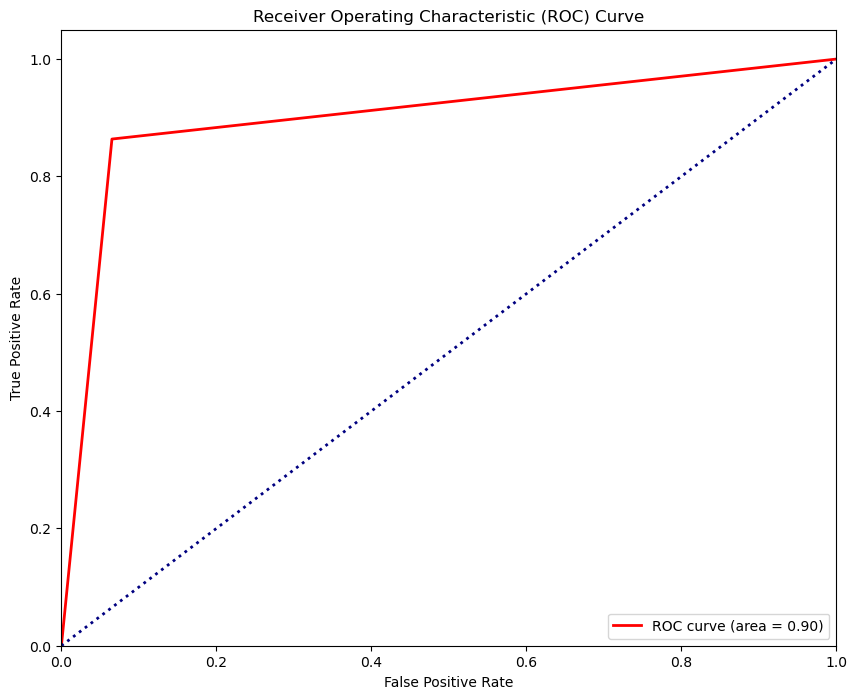

In [ ]:
y_test_numeric= [1 if label == 'fire' else 0 for label in y_test]
y_pred_numeric= [1 if label == 'fire' else 0 for label in prediction_label]

fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_numeric, pos_label=1)
roc_auc_cnn = auc(fpr, tpr)

auc_plotter(roc_auc_cnn)

### Tunisia Example

In [ ]:
from tensorflow.keras.preprocessing import image

# Load and preprocess your image
def process_img(image_path, target_size=(256, 256)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale the pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

cwd = os.getcwd()
tunis_image = os.path.join(cwd, "Tunisia-wildfire.png")
t_image = process_img(tunis_image)

In [ ]:
prediction = np.argmax(model.predict(t_image), axis=1)

prediction

1/1 [==============================] - 0s 56ms/step


array([0], dtype=int64)

### VGG-16 Model

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
batch_size= 32

vgg_tr_dg= ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=image_augmenter)
vgg_training_generator = vgg_tr_dg.flow_from_dataframe(training_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = 32,
                                                    target_size = (224,224),
                                                    class_mode = 'categorical')

vgg_val_dg = ImageDataGenerator(dtype='float32', rescale= 1./255.)
vgg_validation_generator = vgg_val_dg.flow_from_dataframe(val_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = 32,
                                                    target_size = (224,224),
                                                    class_mode = 'categorical')
vgg_te_dg = ImageDataGenerator(dtype='float32', rescale= 1./255.)
vgg_testing_generator = vgg_te_dg.flow_from_dataframe(testing_data_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=False,
                                                    batch_size = 32,
                                                    target_size = (224,224),
                                                    class_mode = 'categorical')

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) # 2 classes

model = Model(inputs=base_model.input, outputs=predictions)

num_classes = len(vgg_training_generator.class_indices)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','AUC'])

Found 1465 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


In [ ]:
epochs = 15
stopping = EarlyStopping(monitor= 'val_loss', patience= 9)
vgg_history= model.fit(vgg_training_generator, epochs=epochs, verbose=1, validation_data=vgg_validation_generator,
          callbacks = [stopping])

Epoch 1/15
30/46 [==================>...........] - ETA: 7:33 - loss: 2.1157 - accuracy: 0.4963 - auc: 0.4871

KeyboardInterrupt: 

In [ ]:
plt.plot(vgg_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation')

plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

plt.plot(vgg_history.history['loss'], label='Training Loss')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

In [ ]:
prediction = np.argmax(model.predict(testing_generator), axis=1)

labels = (testing_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction_label = [labels[k] for k in prediction]
y_test = list(testing_data_df.Label)

# Print accuracy score
score = accuracy_score(y_test,prediction_label)
print(f'Accuracy score: {score * 100}')

# Plot confusion matrix
cfm = confusion_matrix(y_test, prediction_label, normalize= None)
plt.figure(figsize = (17,12))
sb.heatmap(cfm, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()

In [ ]:
print('\n---------------------VGG-16---------------------\n')
print(classification_report(y_test,prediction_label))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0, len(x_test) - 1, 9)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_generator.filepaths[random_index[i]]))
    if labels[testing_generator.labels[random_index[i]]] == prediction_label[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"Actual: {labels[testing_generator.labels[random_index[i]]]}\nPredicted: {prediction_label[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()